# Approximate Bayesian Ensembling - Regression

In [2]:
#import necessary libraries
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
import tensorflow.compat.v1 as tf #ensure no tf version compatibility issues
tf.disable_v2_behavior() 
tf.compat.v1.enable_eager_execution()
import matplotlib.pyplot as plt
import numpy as np

2024-11-22 22:49:18.799490: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-22 22:49:18.824517: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-22 22:49:18.824556: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-22 22:49:18.824571: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-22 22:49:18.829542: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-22 22:49:18.830319: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

Instructions for updating:
non-resource variables are not supported in the long term


In [12]:
# NN parameters
n_ensemble = 10	# no. of NNs in ensemble
reg = 'anc'		# type of regularisation to use - anc (anchoring) reg (regularised) free (unconstrained)
n_hidden = 40 	# no. hidden units in NN
activation_in = 'tanh' # tanh relu sigmoid
data_noise = 0.001 # estimated noise variance
n_data = 6

# optimisation options
epochs = 200 		# run reg for 15+ epochs seems to mess them up
l_rate = 0.001 		# learning rate

# variance of priors
W1_var = 20/1		# 1st layer weights and biases
W_mid_var = 1/n_hidden	# 2nd layer weights and biases
W_last_var = 1/n_hidden	# 3rd layer weights

In [13]:
def fn_make_data():
    # create some data
    x_train = np.atleast_2d([1., 4.5, 5.1, 6., 8., 9.]).T
    x_train = x_train/5. - 1
    y_train = x_train * np.sin(x_train*5.)

    # create validation data - here we'll just a 1-d grid
    x_val = np.atleast_2d(np.linspace(-3, 3, 100)).T
    y_val = np.expand_dims(x_val[:,0],1) # just dummy data
    
    return x_train, y_train, x_val, y_val

In [14]:
# NN object
def fn_make_NN(reg='anc', activation_in='relu'):

	# get initialisations, and regularisation values
	W1_lambda = data_noise/W1_var
	W1_anc = np.random.normal(loc=0,scale=np.sqrt(W1_var),size=[1,n_hidden])
	W1_init = np.random.normal(loc=0,scale=np.sqrt(W1_var),size=[1,n_hidden])

	b1_var = W1_var
	b1_lambda =  data_noise/b1_var
	b1_anc = np.random.normal(loc=0,scale=np.sqrt(b1_var),size=[n_hidden])
	b1_init = np.random.normal(loc=0,scale=np.sqrt(b1_var),size=[n_hidden])

	W_mid_lambda = data_noise/W_mid_var
	W_mid_anc = np.random.normal(loc=0,scale=np.sqrt(W_mid_var),size=[n_hidden,n_hidden])
	W_mid_init = np.random.normal(loc=0,scale=np.sqrt(W_mid_var),size=[n_hidden,n_hidden])

	b_mid_var = W_mid_var
	b_mid_lambda =  data_noise/b_mid_var
	b_mid_anc = np.random.normal(loc=0,scale=np.sqrt(b_mid_var),size=[n_hidden])
	b_mid_init = np.random.normal(loc=0,scale=np.sqrt(b_mid_var),size=[n_hidden])
    
	W_last_lambda = data_noise/W_last_var
	W_last_anc = np.random.normal(loc=0,scale=np.sqrt(W_last_var),size=[n_hidden, 1])
	W_last_init = np.random.normal(loc=0,scale=np.sqrt(W_last_var),size=[n_hidden, 1])

	# create custom regularised
	def custom_reg_W1(weight_matrix):
		if reg == 'reg':
			return K.sum(K.square(weight_matrix)) * W1_lambda/n_data
		elif reg == 'free':
			return 0.
		elif reg == 'anc':
			return K.sum(K.square(weight_matrix - W1_anc)) * W1_lambda/n_data

	def custom_reg_b1(weight_matrix):
		if reg == 'reg':
			return K.sum(K.square(weight_matrix)) * b1_lambda/n_data
		elif reg == 'free':
			return 0.
		elif reg == 'anc':
			return K.sum(K.square(weight_matrix - b1_anc)) * b1_lambda/n_data

	def custom_reg_W_mid(weight_matrix):
		if reg == 'reg':
			return K.sum(K.square(weight_matrix)) * W_mid_lambda/n_data
		elif reg == 'free':
			return 0.
		elif reg == 'anc':
			return K.sum(K.square(weight_matrix - W_mid_anc)) * W_mid_lambda/n_data

	def custom_reg_b_mid(weight_matrix):
		if reg == 'reg':
			return K.sum(K.square(weight_matrix)) * b_mid_lambda/n_data
		elif reg == 'free':
			return 0.
		elif reg == 'anc':
			return K.sum(K.square(weight_matrix - b_mid_anc)) * b_mid_lambda/n_data

	def custom_reg_W_last(weight_matrix):
		if reg == 'reg':
			return K.sum(K.square(weight_matrix)) * W_last_lambda/n_data
		elif reg == 'free':
			return 0.
		elif reg == 'anc':
			return K.sum(K.square(weight_matrix - W_last_anc)) * W_last_lambda/n_data

	model = Sequential()
	model.add(Dense(n_hidden, activation=activation_in, input_shape=(1,),
		kernel_initializer=keras.initializers.Constant(value=W1_init),
		bias_initializer=keras.initializers.Constant(value=b1_init),
		kernel_regularizer=custom_reg_W1,
		bias_regularizer=custom_reg_b1))

	model.add(Dense(n_hidden, activation=activation_in,
		kernel_initializer=keras.initializers.Constant(value=W_mid_init),
		bias_initializer=keras.initializers.Constant(value=b_mid_init),
		kernel_regularizer=custom_reg_W_mid,
		bias_regularizer=custom_reg_b_mid))

	model.add(Dense(1, activation='linear',use_bias=False,
		kernel_initializer=keras.initializers.Constant(value=W_last_init),
		kernel_regularizer=custom_reg_W_last))

	model.compile(loss='mean_squared_error', 
		optimizer=keras.optimizers.Adam(lr=l_rate))

	return model


def fn_predict_ensemble(NNs, x_test):
	''' fn to predict given a list of NNs (an ensemble)''' 
	y_preds = []
	for m in range(len(NNs)):
		y_preds.append(NNs[m].predict(x_test, verbose=0))
	y_preds = np.array(y_preds)

	y_preds_mu = np.mean(y_preds,axis=0)
	y_preds_std = np.std(y_preds,axis=0)

	return y_preds, y_preds_mu, y_preds_std

In [15]:
# create some data
x_train, y_train, x_test, y_test = fn_make_data()

# create the NNs
NNs=[]
for m in range(n_ensemble):
	NNs.append(fn_make_NN(reg=reg, activation_in=activation_in))
print(NNs[-1].summary())

Model: "sequential_109"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_327 (Dense)           (None, 40)                80        
                                                                 
 dense_328 (Dense)           (None, 40)                1640      
                                                                 
 dense_329 (Dense)           (None, 1)                 40        
                                                                 
Total params: 1760 (6.88 KB)
Trainable params: 1760 (6.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


/tmp/ipykernel_22777/500321782.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


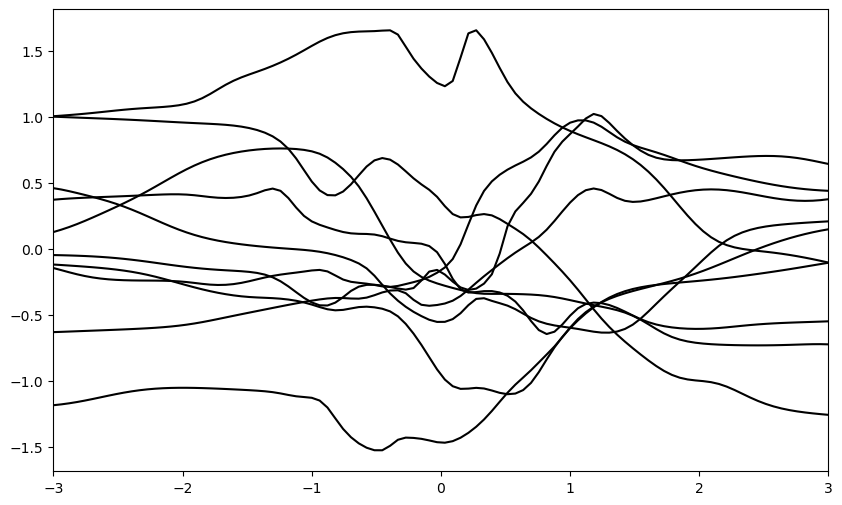

In [16]:
# plot priors
y_preds, y_preds_mu, y_preds_std = fn_predict_ensemble(NNs,x_test)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
for m in range(0,n_ensemble):
    ax.plot(x_test, y_preds[m], 'k')
ax.set_xlim(-3, 3)
fig.show()

In [17]:
# do training
NNs_hist_train=[];
for m in range(n_ensemble):
	print('-- training: ' + str(m+1) + ' of ' + str(n_ensemble) + ' NNs --')
	hist = NNs[m].fit(x_train, y_train,
			  batch_size=n_data,
			  epochs=epochs,
			  verbose=0)
	NNs_hist_train.append(hist.history['loss'])

# make predictions
y_preds, y_preds_mu, y_preds_std = fn_predict_ensemble(NNs,x_test)

-- training: 1 of 10 NNs --
-- training: 2 of 10 NNs --
-- training: 3 of 10 NNs --
-- training: 4 of 10 NNs --
-- training: 5 of 10 NNs --
-- training: 6 of 10 NNs --
-- training: 7 of 10 NNs --
-- training: 8 of 10 NNs --
-- training: 9 of 10 NNs --
-- training: 10 of 10 NNs --


/tmp/ipykernel_22777/1435992827.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


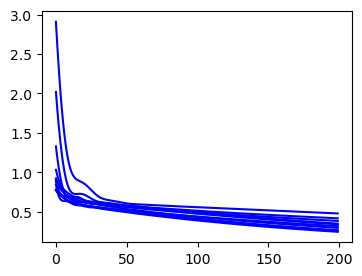

In [18]:
# check how training looked
NNs_hist_train=np.array(NNs_hist_train)
fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(111)
for m in range(n_ensemble):
    ax.plot(NNs_hist_train[m], color='b',label='train')
fig.show()

/tmp/ipykernel_22777/570930486.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


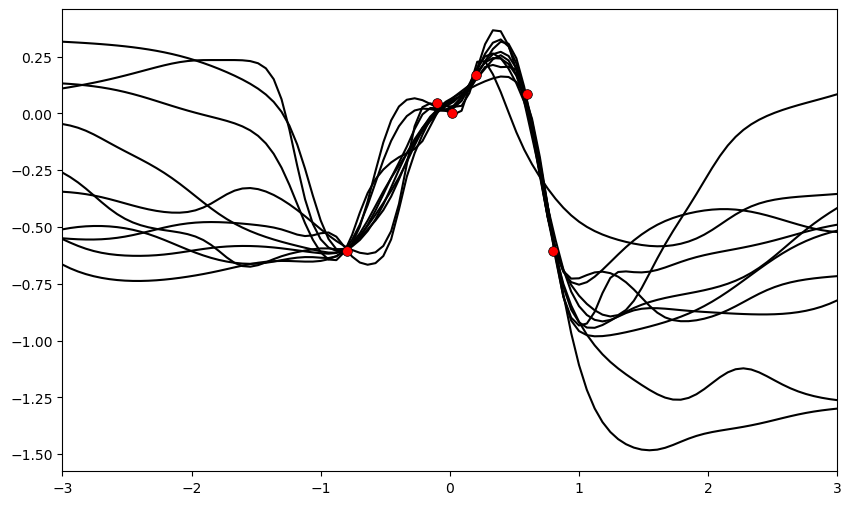

In [19]:
# run predictions
y_preds, y_preds_mu, y_preds_std = fn_predict_ensemble(NNs,x_test)

# plot predictions
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
for m in range(0,n_ensemble):
    ax.plot(x_test, y_preds[m], 'k')
ax.plot(x_train[:,0], y_train, 'r.', markersize=14,
        markeredgecolor='k',markeredgewidth=0.5)
# ax.set_ylim(-4, 2)
ax.set_xlim(-3, 3)
fig.show()

Note that all NNs in the ensemble have converged where training data was present, but maintain diversity elsewhere.

/tmp/ipykernel_22777/802849575.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


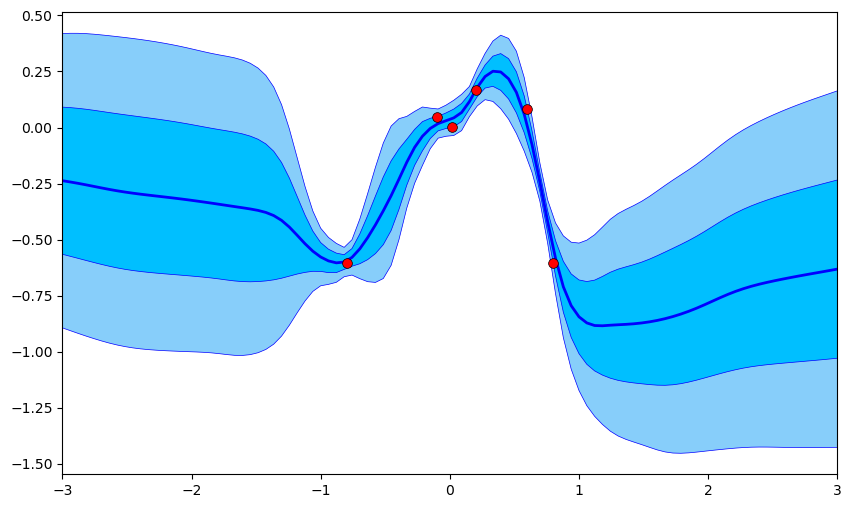

In [20]:
# add on data noise
y_preds_std = np.sqrt(np.square(y_preds_std) + data_noise)

# plot predictive distribution
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(x_test, y_preds_mu, 'b-', linewidth=2.,label=u'Prediction')
ax.plot(x_test, y_preds_mu + 2 * y_preds_std, 'b', linewidth=0.5)
ax.plot(x_test, y_preds_mu - 2 * y_preds_std, 'b', linewidth=0.5)
ax.plot(x_test, y_preds_mu + 1 * y_preds_std, 'b', linewidth=0.5)
ax.plot(x_test, y_preds_mu - 1 * y_preds_std, 'b', linewidth=0.5)
ax.fill(np.concatenate([x_test, x_test[::-1]]),
         np.concatenate([y_preds_mu - 2 * y_preds_std,
                        (y_preds_mu + 2 * y_preds_std)[::-1]]),
         alpha=1, fc='lightskyblue', ec='None')
ax.fill(np.concatenate([x_test, x_test[::-1]]),
         np.concatenate([y_preds_mu - 1 * y_preds_std,
                        (y_preds_mu + 1 * y_preds_std)[::-1]]),
         alpha=1, fc='deepskyblue', ec='None')

ax.plot(x_train[:,0], y_train, 'r.', markersize=14,
        markeredgecolor='k',markeredgewidth=0.5)
# ax.set_ylim(-4, 2)
ax.set_xlim(-3, 3)
fig.show()

-- training: 1 of 10 NNs --
-- training: 2 of 10 NNs --
-- training: 3 of 10 NNs --
-- training: 4 of 10 NNs --
-- training: 5 of 10 NNs --
-- training: 6 of 10 NNs --
-- training: 7 of 10 NNs --
-- training: 8 of 10 NNs --
-- training: 9 of 10 NNs --
-- training: 10 of 10 NNs --


/tmp/ipykernel_22777/77812930.py:46: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


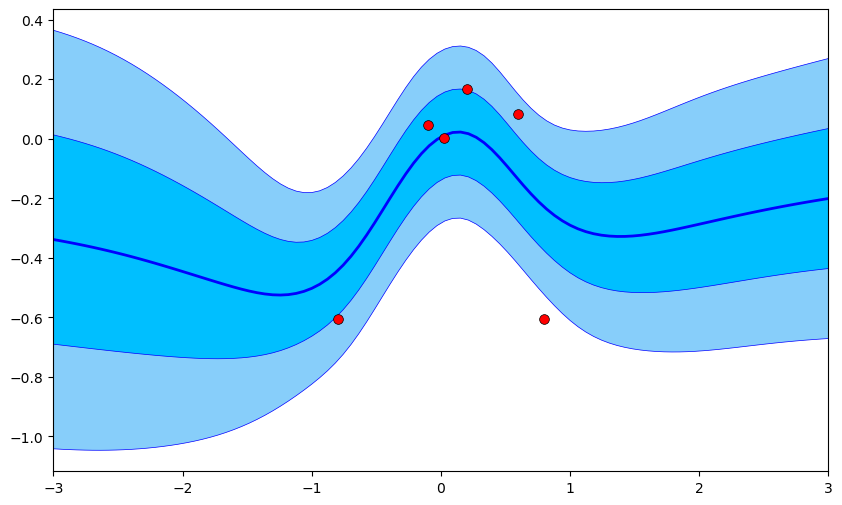

In [21]:
# see how it looks for different prior variance and data noise
activation_in = 'tanh'
data_noise = 0.02
W1_var = 2.0

# create the NNs
NNs=[]
for m in range(n_ensemble):
	NNs.append(fn_make_NN(reg=reg, activation_in=activation_in))

# do training
for m in range(n_ensemble):
	print('-- training: ' + str(m+1) + ' of ' + str(n_ensemble) + ' NNs --')
	hist = NNs[m].fit(x_train, y_train,
			  batch_size=n_data,
			  epochs=epochs,
			  verbose=0)
    
# run predictions
y_preds, y_preds_mu, y_preds_std = fn_predict_ensemble(NNs,x_test)

# add on data noise
y_preds_std = np.sqrt(np.square(y_preds_std) + data_noise)

# plot predictive distribution
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(x_test, y_preds_mu, 'b-', linewidth=2.,label=u'Prediction')
ax.plot(x_test, y_preds_mu + 2 * y_preds_std, 'b', linewidth=0.5)
ax.plot(x_test, y_preds_mu - 2 * y_preds_std, 'b', linewidth=0.5)
ax.plot(x_test, y_preds_mu + 1 * y_preds_std, 'b', linewidth=0.5)
ax.plot(x_test, y_preds_mu - 1 * y_preds_std, 'b', linewidth=0.5)
ax.fill(np.concatenate([x_test, x_test[::-1]]),
         np.concatenate([y_preds_mu - 2 * y_preds_std,
                        (y_preds_mu + 2 * y_preds_std)[::-1]]),
         alpha=1, fc='lightskyblue', ec='None')
ax.fill(np.concatenate([x_test, x_test[::-1]]),
         np.concatenate([y_preds_mu - 1 * y_preds_std,
                        (y_preds_mu + 1 * y_preds_std)[::-1]]),
         alpha=1, fc='deepskyblue', ec='None')

ax.plot(x_train[:,0], y_train, 'r.', markersize=14,
        markeredgecolor='k',markeredgewidth=0.5)
# ax.set_ylim(-4, 2)
ax.set_xlim(-3, 3)
fig.show()

-- training: 1 of 10 NNs --
-- training: 2 of 10 NNs --
-- training: 3 of 10 NNs --
-- training: 4 of 10 NNs --
-- training: 5 of 10 NNs --
-- training: 6 of 10 NNs --
-- training: 7 of 10 NNs --
-- training: 8 of 10 NNs --
-- training: 9 of 10 NNs --
-- training: 10 of 10 NNs --


/tmp/ipykernel_22777/1529026925.py:46: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


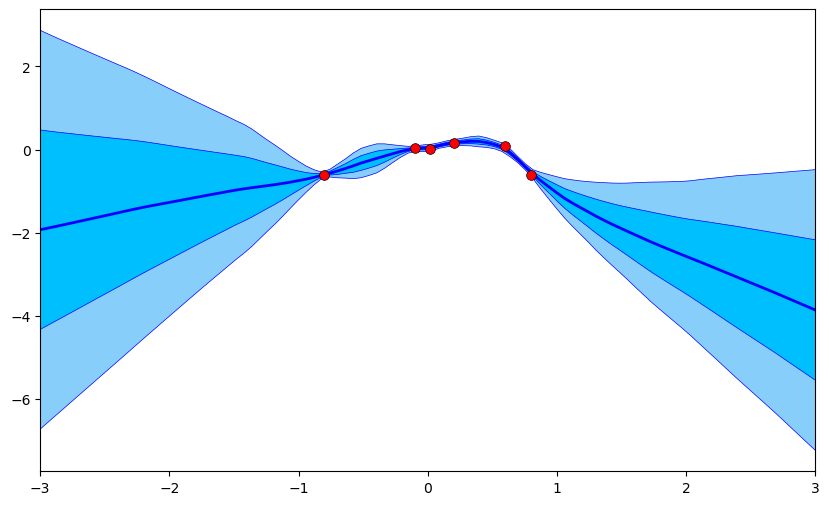

In [22]:
# see how it looks for relu
activation_in = 'relu'
data_noise = 0.001
W1_var = 10

# create the NNs
NNs=[]
for m in range(n_ensemble):
	NNs.append(fn_make_NN(reg=reg, activation_in=activation_in))

# do training
for m in range(n_ensemble):
	print('-- training: ' + str(m+1) + ' of ' + str(n_ensemble) + ' NNs --')
	hist = NNs[m].fit(x_train, y_train,
			  batch_size=n_data,
			  epochs=epochs,
			  verbose=0)
    
# run predictions
y_preds, y_preds_mu, y_preds_std = fn_predict_ensemble(NNs,x_test)

# add on data noise
y_preds_std = np.sqrt(np.square(y_preds_std) + data_noise)

# plot predictive distribution
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(x_test, y_preds_mu, 'b-', linewidth=2.,label=u'Prediction')
ax.plot(x_test, y_preds_mu + 2 * y_preds_std, 'b', linewidth=0.5)
ax.plot(x_test, y_preds_mu - 2 * y_preds_std, 'b', linewidth=0.5)
ax.plot(x_test, y_preds_mu + 1 * y_preds_std, 'b', linewidth=0.5)
ax.plot(x_test, y_preds_mu - 1 * y_preds_std, 'b', linewidth=0.5)
ax.fill(np.concatenate([x_test, x_test[::-1]]),
         np.concatenate([y_preds_mu - 2 * y_preds_std,
                        (y_preds_mu + 2 * y_preds_std)[::-1]]),
         alpha=1, fc='lightskyblue', ec='None')
ax.fill(np.concatenate([x_test, x_test[::-1]]),
         np.concatenate([y_preds_mu - 1 * y_preds_std,
                        (y_preds_mu + 1 * y_preds_std)[::-1]]),
         alpha=1, fc='deepskyblue', ec='None')

ax.plot(x_train[:,0], y_train, 'r.', markersize=14,
        markeredgecolor='k',markeredgewidth=0.5)
# ax.set_ylim(-4, 2)
ax.set_xlim(-3, 3)
fig.show()